<a href="https://colab.research.google.com/github/raju-cse/knowledge-graph/blob/main/Students'_Social_Media_Addiction_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
! git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
# Install necessary packages
!pip install neo4j py2neo pandas matplotlib seaborn plotly scipy

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from py2neo import Graph, Node, Relationship
import warnings

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Start Neo4j service (in Colab we'll use the free Neo4j AuraDB)
# For a real project, you would set up a proper Neo4j instance

# Connect to Neo4j (replace with your credentials)
neo4j_uri = "neo4j+s://f5a5b350.databases.neo4j.io"
neo4j_user = "neo4j"
neo4j_password = "6ImJ2-NtCsDYNBvfiXuA_l6RpfmQ5QYh11Ge9O7Vuqw"


try:
    graph = Graph(neo4j_uri, auth=(neo4j_user, neo4j_password))
    graph.run("MATCH (n) RETURN count(n)")  # Test connection
    print("Successfully connected to Neo4j")
except Exception as e:
    print("Failed to connect to Neo4j:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 17.8 MB/s eta 0:00:00
Successfully connected to Neo4j


In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/knowledge graph/Students Social Media Addiction.csv")

# Create additional features as before
bins = [15, 20, 25, 30, 35]
labels = ['16-20', '21-25', '26-30', '31-35']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

usage_bins = [0, 2, 4, 6, 12, 24]
usage_labels = ['Minimal (0-2h)', 'Moderate (2-4h)', 'High (4-6h)', 'Very High (6-12h)', 'Extreme (12h+)']
df['Usage_Category'] = pd.cut(df['Avg_Daily_Usage_Hours'], bins=usage_bins, labels=usage_labels)

sleep_bins = [0, 5, 7, 9, 12]
sleep_labels = ['Poor (<5h)', 'Fair (5-7h)', 'Good (7-9h)', 'Excellent (9h+)']
df['Sleep_Category'] = pd.cut(df['Sleep_Hours_Per_Night'], bins=sleep_bins, labels=sleep_labels)

# Clear existing data (for demo purposes)
graph.run("MATCH (n) DETACH DELETE n")

# Create constraints for better performance
graph.run("CREATE CONSTRAINT student_id IF NOT EXISTS FOR (s:Student) REQUIRE s.student_id IS UNIQUE")
graph.run("CREATE CONSTRAINT platform_name IF NOT EXISTS FOR (p:Platform) REQUIRE p.name IS UNIQUE")
graph.run("CREATE CONSTRAINT country_name IF NOT EXISTS FOR (c:Country) REQUIRE c.name IS UNIQUE")

# Import data to Neo4j
for _, row in df.iterrows():
    # Create Student node
    student = Node("Student",
                  student_id=row['Student_ID'],
                  age=row['Age'],
                  gender=row['Gender'],
                  academic_level=row['Academic_Level'],
                  avg_daily_usage=row['Avg_Daily_Usage_Hours'],
                  usage_category=row['Usage_Category'],
                  sleep_hours=row['Sleep_Hours_Per_Night'],
                  sleep_category=row['Sleep_Category'],
                  mental_health_score=row['Mental_Health_Score'],
                  relationship_status=row['Relationship_Status'],
                  conflicts_score=row['Conflicts_Over_Social_Media'],
                  addiction_score=row['Addicted_Score'])

    graph.create(student)

    # Create or connect Platform node
    platform = Node("Platform", name=row['Most_Used_Platform'])
    graph.merge(platform, "Platform", "name")
    uses = Relationship(student, "USES", platform)
    graph.create(uses)

    # Create or connect Country node
    country = Node("Country", name=row['Country'])
    graph.merge(country, "Country", "name")
    from_country = Relationship(student, "FROM", country)
    graph.create(from_country)

    # Connect academic performance
    perf = "Affects" if row['Affects_Academic_Performance'] == "Yes" else "DoesNotAffect"
    performance = Relationship(student, perf, Node("AcademicPerformance"))
    graph.create(performance)

print("Data imported to Neo4j successfully")

Data imported to Neo4j successfully


Most popular platforms among addicted students:
    platform  count
0  Instagram    153
1     TikTok    133
2   WhatsApp     54
3   Facebook     34
4   Snapchat     12


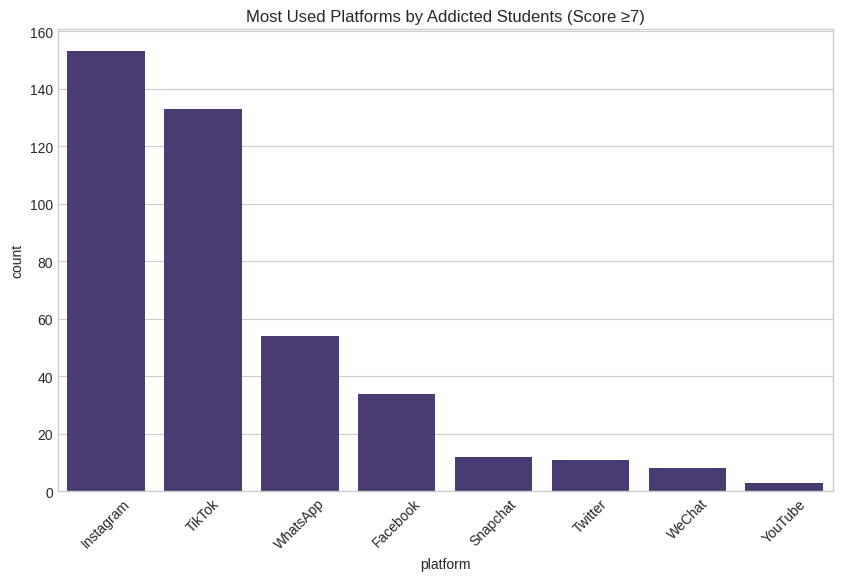


Academic Performance Impact by Usage Category:
performance_impact  Affects  DoesNotAffect  Affects_Percentage
usage_category                                                
High (4-6h)           284.0          109.0           72.264631
Minimal (0-2h)          0.0            2.0            0.000000
Moderate (2-4h)        26.0          141.0           15.568862
Very High (6-12h)     143.0            0.0          100.000000

Platforms associated with poor mental health (score <5):
    platform  avg_sleep_hours  avg_addiction_score  count
0  Instagram         5.653333             8.933333     15
1     TikTok         5.610000             9.000000     10
2   Facebook         5.766667             9.000000      3
3   Snapchat         5.200000             9.000000      1

Countries with highest average addiction scores:
          country  avg_addiction_score  avg_mental_health  sample_size
0         Ecuador                9.000                5.0            1
1  Czech Republic                9

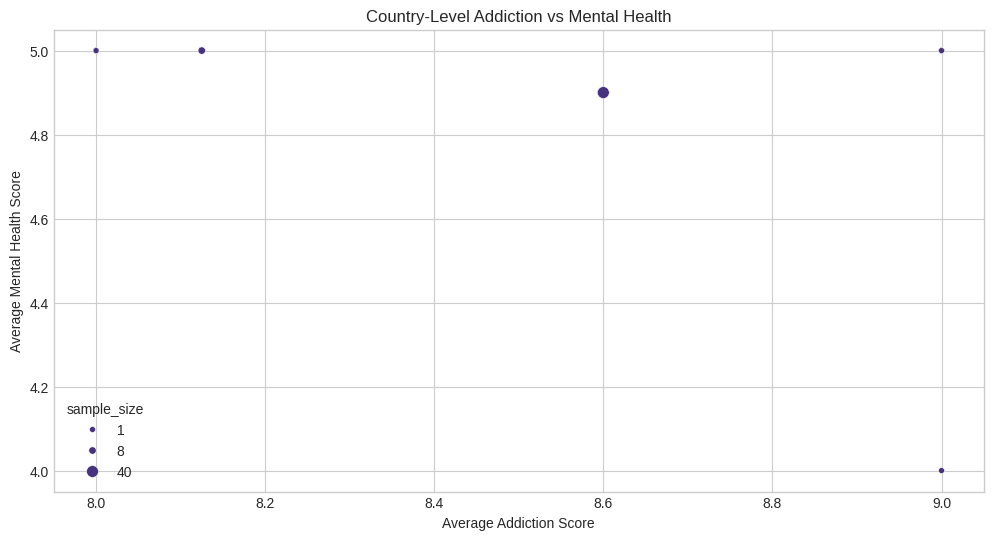

In [ ]:
# 1. Most popular platforms among highly addicted students
query = """
MATCH (s:Student)-[:USES]->(p:Platform)
WHERE s.addiction_score >= 7
RETURN p.name AS platform, COUNT(*) AS count
ORDER BY count DESC
"""
popular_platforms = graph.run(query).to_data_frame()
print("Most popular platforms among addicted students:")
print(popular_platforms.head())

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='platform', y='count', data=popular_platforms)
plt.title('Most Used Platforms by Addicted Students (Score ≥7)')
plt.xticks(rotation=45)
plt.show()

# 2. Relationship between usage and academic performance
query = """
MATCH (s:Student)-[r]->(:AcademicPerformance)
RETURN
  s.usage_category AS usage_category,
  TYPE(r) AS performance_impact,
  COUNT(*) AS count
ORDER BY usage_category, performance_impact
"""
performance_impact = graph.run(query).to_data_frame()
performance_pivot = performance_impact.pivot(index='usage_category',
                                           columns='performance_impact',
                                           values='count').fillna(0)
performance_pivot['Affects_Percentage'] = (performance_pivot['Affects'] /
                                         (performance_pivot['Affects'] + performance_pivot['DoesNotAffect'])) * 100

print("\nAcademic Performance Impact by Usage Category:")
print(performance_pivot)

# 3. Path analysis: How platform choice affects mental health through sleep
query = """
MATCH (p:Platform)<-[:USES]-(s:Student)
WHERE s.mental_health_score < 5
RETURN
  p.name AS platform,
  AVG(s.sleep_hours) AS avg_sleep_hours,
  AVG(s.addiction_score) AS avg_addiction_score,
  COUNT(*) AS count
ORDER BY count DESC
LIMIT 5
"""
mental_health_paths = graph.run(query).to_data_frame()
print("\nPlatforms associated with poor mental health (score <5):")
print(mental_health_paths)

# 4. Country-level analysis of social media addiction
query = """
MATCH (s:Student)-[:FROM]->(c:Country)
RETURN
  c.name AS country,
  AVG(s.addiction_score) AS avg_addiction_score,
  AVG(s.mental_health_score) AS avg_mental_health,
  COUNT(*) AS sample_size
ORDER BY avg_addiction_score DESC
LIMIT 10
"""
country_analysis = graph.run(query).to_data_frame()
print("\nCountries with highest average addiction scores:")
print(country_analysis)

# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(x='avg_addiction_score', y='avg_mental_health',
                size='sample_size', data=country_analysis)
plt.title('Country-Level Addiction vs Mental Health')
plt.xlabel('Average Addiction Score')
plt.ylabel('Average Mental Health Score')
plt.show()

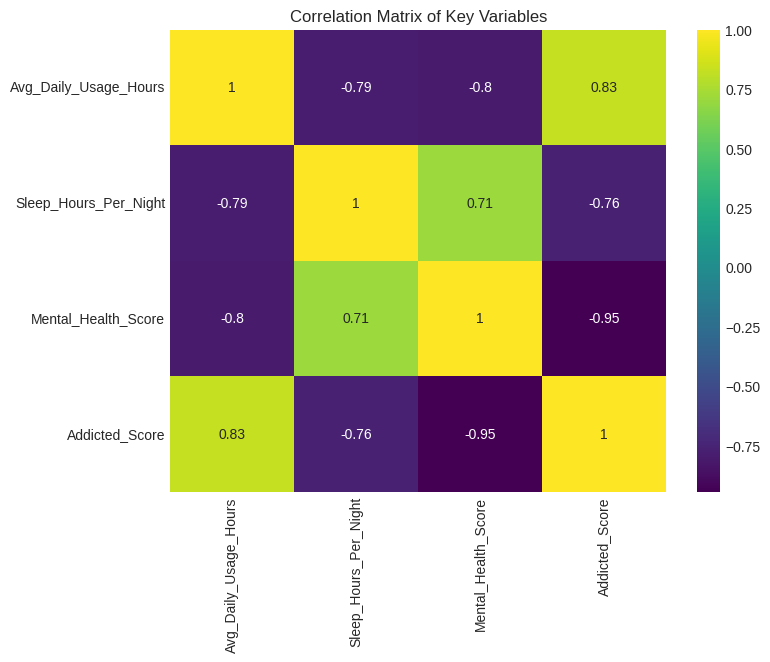


Graph-calculated covariances:
   covariance_usage_addiction  covariance_sleep_mentalhealth
0                    1.658061                       0.879674


In [ ]:
# Compare with traditional correlation analysis
corr_matrix = df[['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
                 'Mental_Health_Score', 'Addicted_Score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix of Key Variables')
plt.show()

# Graph-based correlation verification
query = """
MATCH (s:Student)
RETURN
  AVG(s.avg_daily_usage * s.addiction_score) - AVG(s.avg_daily_usage) * AVG(s.addiction_score) AS covariance_usage_addiction,
  AVG(s.sleep_hours * s.mental_health_score) - AVG(s.sleep_hours) * AVG(s.mental_health_score) AS covariance_sleep_mentalhealth
"""
graph_correlations = graph.run(query).to_data_frame()
print("\nGraph-calculated covariances:")
print(graph_correlations)

In [ ]:
# 1. Identify influencer platforms (used by highly addicted students)
query = """
MATCH (p:Platform)<-[:USES]-(s:Student)
WHERE s.addiction_score >= 8
WITH p, COUNT(*) AS addicted_users
ORDER BY addicted_users DESC
LIMIT 5
MATCH (p)<-[:USES]-(s2:Student)
RETURN
  p.name AS platform,
  addicted_users,
  AVG(s2.addiction_score) AS avg_addiction_score,
  AVG(s2.mental_health_score) AS avg_mental_health
"""
influencer_platforms = graph.run(query).to_data_frame()
print("\nTop influencer platforms among highly addicted students:")
print(influencer_platforms)

# 2. Find students at risk (high addiction, poor mental health, poor sleep)
query = """
MATCH (s:Student)
WHERE s.addiction_score >= 7 AND s.mental_health_score <= 5 AND s.sleep_category = 'Poor (<5h)'
RETURN
  s.student_id AS student_id,
  s.age AS age,
  s.gender AS gender,
  s.addiction_score AS addiction_score,
  s.mental_health_score AS mental_health_score,
  [(s)-[:USES]->(p) | p.name][0] AS main_platform
ORDER BY s.addiction_score DESC
LIMIT 10
"""
at_risk_students = graph.run(query).to_data_frame()
print("\nStudents at highest risk:")
print(at_risk_students)

# 3. Platform crossover analysis (what other platforms do users of X platform use)
query = """
MATCH (p:Platform)<-[:USES]-(s:Student)-[:USES]->(other:Platform)
WHERE p.name = 'Instagram' AND other.name <> 'Instagram'
RETURN
  other.name AS co_used_platform,
  COUNT(*) AS count,
  AVG(s.addiction_score) AS avg_addiction_score
ORDER BY count DESC
LIMIT 5
"""
platform_crossover = graph.run(query).to_data_frame()
print("\nPlatforms commonly used with Instagram:")
print(platform_crossover)


Top influencer platforms among highly addicted students:
    platform  addicted_users  avg_addiction_score  avg_mental_health
0     TikTok              78             7.428571           5.714286
1  Instagram              63             6.554217           6.124498
2   WhatsApp              25             7.462963           5.537037
3   Facebook              22             5.666667           6.715447
4   Snapchat               6             7.461538           5.538462

Students at highest risk:
   student_id  age  gender  addiction_score  mental_health_score main_platform
0           6   19  Female                9                    4     Instagram
1         317   19  Female                9                    4     Instagram
2         377   19  Female                9                    5     Instagram
3         387   20  Female                9                    5        TikTok
4         397   19  Female                9                    5     Instagram
5         407   20  Female 

In [ ]:
# Interactive visualization of platform relationships

query = """
MATCH (s:Student)-[:USES]->(p:Platform)
RETURN
  p.name AS platform,
  COUNT(s) AS student_count
ORDER BY student_count DESC
LIMIT 10
"""
platform_network = graph.run(query).to_data_frame()

# Create network visualization
fig = px.bar(platform_network,
                 x='platform',
                 y='student_count',
                 title='Number of Students per Platform')
fig.update_layout(width=800, height=500)
fig.show()

# Country-level addiction patterns
query = """
MATCH (c:Country)<-[:FROM]-(s:Student)
WITH c, AVG(s.addiction_score) AS avg_score
WHERE avg_score >= 6
RETURN c.name AS country, avg_score
ORDER BY avg_score DESC
"""
country_addiction = graph.run(query).to_data_frame()

fig = px.choropleth(country_addiction,
                    locations='country',
                    locationmode='country names',
                    color='avg_score',
                    title='Average Social Media Addiction Score by Country')
fig.update_layout(width=800, height=500)
fig.show()

In [ ]:
# Build a simple recommendations engine based on graph patterns
def get_recommendations(student_id):
    query = """
    MATCH (s:Student {student_id: $student_id})-[:USES]->(p:Platform)
    MATCH (s)-[:FROM]->(c:Country)

    // Find similar students (same country, similar usage)
    MATCH (similar:Student)-[:FROM]->(c)
    WHERE similar.student_id <> $student_id
    AND abs(similar.avg_daily_usage - s.avg_daily_usage) < 1
    AND similar.mental_health_score > s.mental_health_score

    // Find platforms they use with better outcomes
    MATCH (similar)-[:USES]->(rec_platform:Platform)
    WHERE NOT (s)-[:USES]->(rec_platform)

    RETURN
      rec_platform.name AS recommended_platform,
      AVG(similar.mental_health_score) AS avg_mental_health,
      AVG(similar.sleep_hours) AS avg_sleep_hours,
      COUNT(*) AS supporting_students
    ORDER BY supporting_students DESC
    LIMIT 3
    """
    # Convert student_id to a standard Python integer
    return graph.run(query, student_id=int(student_id)).to_data_frame()

# Test with a sample student
sample_student = df[df['Mental_Health_Score'] < 5]['Student_ID'].iloc[0]
recommendations = get_recommendations(sample_student)
print(f"\nRecommendations for student {sample_student}:")
print(recommendations)


Recommendations for student 6:
Empty DataFrame
Columns: []
Index: []
